# Base Case

The purpose of this notebook is to derive a base case for comparison in regards to model training time.  The data for this evaluation was taken from *Wigren, T. et al.* and is available for direct download at http://www.it.uu.se/research/publications/reports/2010-020/NonlinearData.zip.  This gives a *.mat* file format that was then processed into a csv as shown for this analysis, noting that in the .mat file, `y[0]` is tank two's height and `y[1]` is tank one's height.  Of the two datasets provided from the source, this analysis only looks at the first one.  The dataset was then processed to calculate the derivatives via finite differences.

In [1]:
# Import Relevant Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

# Load in data
df = pd.read_csv('data/dataset1.csv')

## Part 1: Training the GPs

For a base case, we can directly train a GP using the derivative and state estimations from the cleaned dataset.  The Matern kernel with a $\nu$ value of 0.5 was chosen due to the very sporadic dynamics of the system.  Using the RBF kernel failed to appropriately capture the dynamics and higher values of $\nu$ lead to larger errors.

For the training of the models, 80% of the data is taken for training, leaving 20% for validation.  With 2500 total data points, this leads to training on 2000.  Because of the time dependent nature of the data, it was decided to use the first 10,000 consecutive seconds of data to be more similar to other methodologies that predict dynamics (such as NARX); however, with the way the problem was formulated, this could be trained using a shuffled set of training data.

In [2]:
# Function to create and train a Gaussian Process model
def train_gp(X, y):
    kernel = Matern(nu = 0.5)
    gp = GaussianProcessRegressor(kernel=kernel, 
                                  n_restarts_optimizer=10, # Added as due to initial accuracy issues
                                  random_state=42)
    gp.fit(X.values, y.values)
    return gp

X = df[['u', 'h1', 'h2']]
X_train = X[0:2000]
y1 = df['h1_der'][0:2000]
y2 = df['h2_der'][0:2000]

print("Training Gaussian Process for dh1.")
gp_model_dh1 = train_gp(X_train, y1)
print("Training Gaussian Process for dh2.")
gp_model_dh2 = train_gp(X_train, y2)
print("Finished!")

Training Gaussian Process for dh1.


c:\Users\Michael\anaconda3\envs\online_update_controls\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Training Gaussian Process for dh2.
Finished!


## Part 2: State Predictions

Now, having learned the dynamics of the system, it is possible to solve for the system states.  The way this was done is that given the initial conditions and the ODE's represented by the Gaussian Processes, it can be integrated over.  The forward Euler method was chosen for it's simplicity in this case.

In [3]:
# Create vector of times and pump signals
tvec = df["time"].values
u = df['u'].values
# Create blank vectors for h1 and h2 values
h1 = np.zeros_like(tvec, dtype=float)
h2 = np.zeros_like(tvec, dtype=float)

# Initial Conditions
h1[0] = df["h1"].values[0]
h2[0] = df["h2"].values[0]
# Integration using forward Euler
for i in range(len(tvec) - 1):
    h1[i + 1] = h1[i] + 5 * gp_model_dh1.predict(np.array([[u[i], h1[i], h2[i]]])).item()
    h2[i + 1] = h2[i] + 5 * gp_model_dh2.predict(np.array([[u[i], h1[i], h2[i]]])).item()

df['h1_prediction'] = h1
df['h2_prediction'] = h2

## Part 3: Validation
For the validation metric, we look at the last 2500 seconds worth of data that was not given to the models. The Mean Squared Error (MSE) between the data and predictions at this point will serve as the accuracy metric to compare to other methodologies.

In [4]:
MSE = np.sum((df['h2'][2000:-1] - df['h2_prediction'][2000:-1])**2)/len(df)
print('The MSE for the Base Case is:', round(MSE,4))

The MSE for the Base Case is: 0.0087


The below graphic gives a visual representation of the overall predictions.

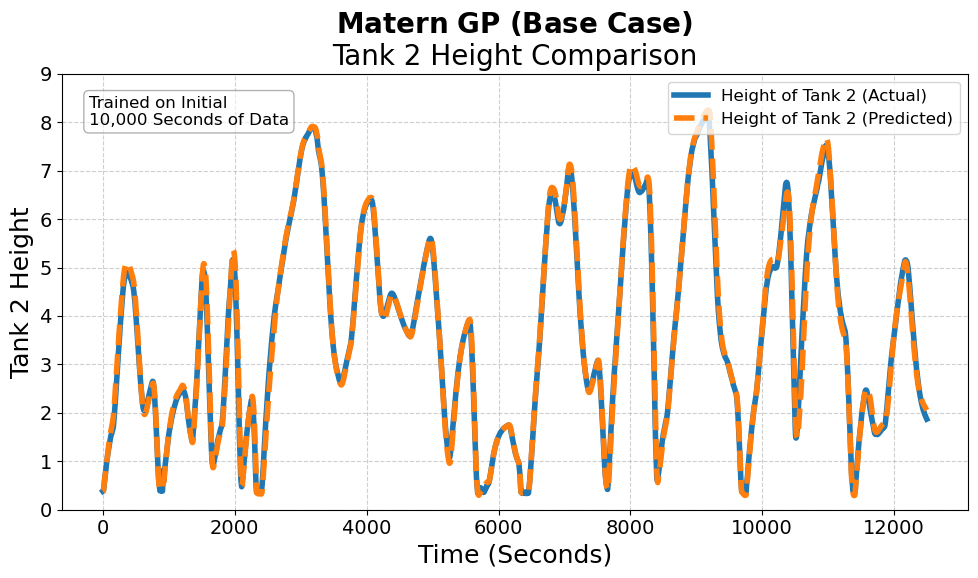

In [5]:
# Plot with improved aesthetics
plt.rcParams.update({'font.size': 14})  # Adjust the number to increase/decrease font size
fig, ax = plt.subplots(figsize=(10, 6))

# Plot both the actual and predicted data
ax.plot(df['time'], df['h2'], label='h1', linewidth=4, linestyle='-')#, color='blue')
ax.plot(df['time'], df['h2_prediction'], label='h2_prediction', linewidth=4, linestyle='--')#, color='red')

# Enhancing the graph with titles, labels, and grid
ax.set_title(r'$\bf{Matern\ GP\ (Base\ Case)}$' + '\nTank 2 Height Comparison', fontsize=20)
ax.set_xlabel('Time (Seconds)', fontsize=18)
ax.set_ylabel('Tank 2 Height', fontsize=18)
ax.legend(['Height of Tank 2 (Actual)', 'Height of Tank 2 (Predicted)'], fontsize=12, loc='upper right')

ax.grid(True, linestyle='--', alpha=0.6)

# ax.text(-250, 7, 'Trained on Initial \n10,000 Seconds of Data', fontsize=12, color='black', bbox = dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.4', alpha = 0.6))

# Add a note in the upper-left corner with a rounded box
ax.text(0.03, 0.95, 'Trained on Initial \n10,000 Seconds of Data',
        fontsize=12, color='black',
        bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3', alpha = 0.6),
        transform=ax.transAxes,  # Use normalized coordinates
        verticalalignment='top',  # Align text to the top of the box
        horizontalalignment='left')  # Align text to the left

ax.set_ylim(0, 9)

# Show plot
plt.tight_layout()
plt.show()